In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import humanize

In [2]:
eavs = pd.read_excel('eavs/2024_EAVS_for_Public_Release_V1_xlsx.xlsx') # 6461 rows

# 2026 jurisdiction-level info only (no need for the full VV merged file with equipment across all years)
vv = pd.read_csv('vv_capture_2025-07-23_14-12-58/2026/verifier-jurisdictions.csv', skiprows=1, index_col=False, converters={'FIPS code': str}) # 6374 rows


eavs.rename(columns={
    'Jurisdiction_Name': 'juris',
    'FIPSCode': 'fips'
}, inplace=True)

vv.rename(columns={
    'Jurisdiction': 'juris',
    'FIPS code': 'fips'
}, inplace=True)

eavs['fips'] = eavs['fips'].apply(lambda x: str(x).zfill(10))


## Align FIPS codes across EAVS and VV data

In [3]:
# check how good the FIPS merging will be between VV and EAVS

def missing_fips_coverage(vv, eavs, verbose=False):
    # See how many vv FIPS codes are in eavs
    vv['in_eavs'] = vv['fips'].isin(eavs['fips'])
    coverage_vv = vv['in_eavs'].mean()  # proportion of vv matched
    if verbose:
        print(f"Coverage of vv in eavs: {coverage_vv:.1%}")
        print(vv['in_eavs'].value_counts())
        print('\n')

    # See how many eavs FIPS codes are in vv
    eavs['in_vv'] = eavs['fips'].isin(vv['fips'])
    coverage_eavs = eavs['in_vv'].mean()  # proportion of eavs matched
    if verbose:
        print(f"Coverage of eavs in vv: {coverage_eavs:.1%}")
        print(eavs['in_vv'].value_counts())
        print('\n')

    # Codes in vv but not in eavs
    vv_missing = vv.loc[~vv['in_eavs'], 'fips'].unique()
    return vv_missing

vv_missing = missing_fips_coverage(vv, eavs);

In [4]:
# match WI on counties
wi = vv['State'] == 'Wisconsin'
vv['wi_county'] = vv[wi]['juris'].apply(lambda x: x.split('(')[1].split('County')[0].strip().upper())
vv['wi_jurisdiction'] = vv[wi]['juris'].apply(lambda x: x.split('(')[0].strip().upper())

wi = eavs['State_Full'] == 'WISCONSIN'
eavs.loc[wi, 'wi_county'] = eavs.loc[wi, 'juris'].apply(lambda x: x.split(' - ')[1].split('COUNTY')[0].strip())
eavs.loc[wi, 'wi_jurisdiction'] = eavs.loc[wi, 'juris'].apply(lambda x: x.split(' - ')[0].strip())

county_fips_dict = (
    vv.groupby('wi_county')['fips']
      .apply(lambda x: list({code[:5] for code in x if pd.notnull(code)})[0])
      .to_dict()
)

for name, fips in county_fips_dict.items():
    mask = eavs['wi_county'] == name
    eavs.loc[mask, 'fips'] = fips + eavs.loc[mask, 'fips'].str[5:]

vv_missing = missing_fips_coverage(vv, eavs);

In [5]:
# match WI on jurisdictions
juris_fips_dict = (
    vv.groupby('wi_jurisdiction')['fips']
      .apply(lambda x: list({code for code in x if pd.notnull(code)})[0])
      .to_dict()
)

for name, fips in juris_fips_dict.items():
    if fips in vv_missing:
        mask = eavs['wi_jurisdiction'] == name
        eavs.loc[mask, 'fips'] = fips

vv_missing = missing_fips_coverage(vv, eavs);


In [6]:
# some small fixes
fixes = {
    '2501943790': '2501900000', # Nantucket, MA
    '1100100000': '1100000000', # Washington, DC
}
eavs['fips'] = eavs['fips'].replace(fixes)

# fix NH
for fips in vv[vv['fips'].isin(vv_missing)].drop_duplicates('fips')['fips']:
    eavs.loc[eavs['fips'].str.contains(fips[:-2]), 'fips'] = fips


## Merge datasets, mark BMD/DRE-for-all

In [7]:
# merge VV and EAVS
vv_jurisdiction_cols = ['fips', 'State', 'juris', 'Registered Voters', 'Precincts', 'Voting Location', 'All Mail Ballot?', 'Election Day Marking Method', 'Election Day Tabulation']
eavs = eavs.merge(vv[vv_jurisdiction_cols], on='fips', how='left', suffixes=(None, '_vv'))

In [8]:
# mark BMD/DRE-for-all jurisdictions
bmd_for_all = ['Ballot Marking Devices for all voters']
dre_for_all = ['DREs with VVPAT for all voters', 'DREs without VVPAT for all voters']

eavs[['bmd_for_all', 'dre_for_all', 'bmd_or_dre_for_all']] = False
eavs.loc[eavs['Election Day Marking Method'].isin(bmd_for_all), 'bmd_for_all'] = True
eavs.loc[eavs['Election Day Marking Method'].isin(dre_for_all), 'dre_for_all'] = True
eavs.loc[eavs['bmd_for_all'] | eavs['dre_for_all'], 'bmd_or_dre_for_all'] = True


In [9]:
eavs['A1a'] = pd.to_numeric(eavs['A1a'], errors='coerce')
eavs['A1b'] = pd.to_numeric(eavs['A1b'], errors='coerce')

## Compare registered voter count

Registered Voters    223.6 million
A1a                  234.5 million
A1b                  211.1 million
dtype: object

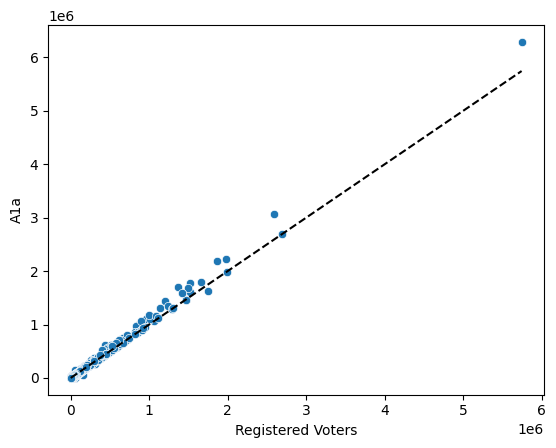

In [10]:
# compare VV and EAVS voter count.
# EAVS Registered voters is higher, likely because VV registered voters is based on 2022 EAVS.

sns.scatterplot(eavs, x='Registered Voters', y='A1a')

plt.plot([0, eavs['Registered Voters'].max()], [0, eavs['Registered Voters'].max()], 'k--')

eavs[['Registered Voters', 'A1a', 'A1b']].sum().apply(humanize.intword)


In [11]:
# for North Dakota, use VV Registered Voters as EAVS Registered Voters and Active Registered Voters.
# (it's identical to the north dakota eligible voters file pulled from the ND SOS website.)
eavs.loc[eavs['State_Full'] == "NORTH DAKOTA", 'A1a'] = eavs.loc[eavs['State_Full'] == "NORTH DAKOTA", 'Registered Voters']
eavs.loc[eavs['State_Full'] == "NORTH DAKOTA", 'A1b'] = eavs.loc[eavs['State_Full'] == "NORTH DAKOTA", 'Registered Voters']

In [ ]:
eavs.to_pickle('merged_eavs_and_vv_data.pkl.zip')